In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax
from scipy import stats
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm

In [2]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

In [3]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'VAC_GC_DR17_synspec_rev1_beta.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7737 GC stars


In [4]:
apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [5]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

536568

In [6]:
# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['LOGG']>1.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['ruwe']<1.4)&\
    (data['parallax']>0.2)&(data['parallax_over_error']>8.)

print('There are '+str(len(data[mask]))+' stars in the parent sample')


There are 174274 stars in the parent sample


In [7]:
import galpy
from galpy.util import coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
from astropy.io import fits
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.conversion import get_physical
from galpy.actionAngle import UnboundError


A new version of galpy (1.9.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [8]:
def dat_to_galcen(dat,
                  return_rphiz =True,
                  verbose =False,
                  ro = 8.275,  # GRAVITY 2018 value 
                  vo = 220.,   # GRAVITY 2018 value 
                  zo = 0.02,    # Bennet and Bovy 2018 value
                  keys = ['RA', 'DEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'pmra', 'pmdec', 'VHELIO_AVG'],
                  #cov_keys = [dat['pmra_error_1'],dat['pmdec_error_1'],dat['SH_weighted_diststd'],dat['VERR_1']],
                  parallax = False):
    vxvv = np.dstack([dat[keys[i]] for i in range(len(keys))])[0]
    ra, dec= vxvv[:,0], vxvv[:,1]
    lb= coords.radec_to_lb(ra,dec,degree=True, epoch=None)
    pmra, pmdec= vxvv[:,3], vxvv[:,4]
    pmllpmbb= coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
    d, vlos= vxvv[:,2]/1e3, vxvv[:,5]
    if parallax:
        d = 1./d
    rectgal= coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
    vsolar= np.array([-8.4,31.8,8.4]) # Values from Ted's halo paper, taken from Schrondich 2010 and adjusted given by the proper motion values for SGR A* by the GRAVITY collaboration. Vx is negative because we adopt the x convention to go in opposite direction
    vsun= np.array([0.,1.,0.,])+vsolar/vo
    X = rectgal[:,0]/ro
    Y = rectgal[:,1]/ro
    Z = rectgal[:,2]/ro
    vx = rectgal[:,3]/vo
    vy = rectgal[:,4]/vo
    vz = rectgal[:,5]/vo
    XYZ = np.dstack([X, Y, Z])[0]
    vxyz = np.dstack([vx,vy,vz])[0]
    Rpz = coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
    vRvTvz = coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                                    vsun=vsun,
                                                                    Xsun=1.,
                                                                    Zsun=zo/ro,
                                                                    galcen=True)
    return XYZ, vxyz, Rpz, vRvTvz


In [9]:
xyz,vxyz,Rpz,vRvTvz = dat_to_galcen(data)

# Plot the kinematic and action 3 panel OTI 

In [10]:
# Eilers rotation curve
R = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(R-8.275)
Rg = (-data['L'][:,2]/vcirc)
phi = np.arctan(data['xyz'][:,1]/-data['xyz'][:,0])
phi_x1 = R*np.cos(phi)
phi_y1 = R*np.sin(phi)
vr = vRvTvz[:,0]*220.
print(R)
deltaR = R-Rg


[ 9.87188323  8.63580707 22.58525074 ...  5.15168728  5.15372958
  5.80486113]


In [42]:
z_x2 = np.sqrt(data['actions'][:,2])*np.cos(data['angles'][:,2])
z_y2 = np.sqrt(data['actions'][:,2])*np.sin(data['angles'][:,2])
R_x2 = np.sqrt(data['actions'][:,0])*np.cos(data['angles'][:,0])
R_y2 = np.sqrt(data['actions'][:,0])*np.sin(data['angles'][:,0])
phi_x2 = -np.sqrt(-data['L'][:,2])*np.cos(data['angles'][:,1])
phi_y2 = -np.sqrt(-data['L'][:,2])*np.sin(data['angles'][:,1])


In [43]:
line = data['FE_H']*-0.167 + 0.12

lowa = ((data['FE_H']>-0.8)&(data['FE_H']<-0.4)&(data['MG_FE']<0.185))|((data['FE_H']>-0.4)&(data['FE_H']<-0.05)&(data['MG_FE']<line))|((data['FE_H']>-0.05)&(data['FE_H']<0.6)&(data['MG_FE']<0.12))


higha = ((data['FE_H']>-1)&(data['FE_H']<-0.4)&(data['MG_FE']>line))|\
((data['FE_H']>-0.4)&(data['FE_H']<0.6)&(data['MG_FE']>0.185))

print(len(data[mask&lowa]))
print(len(data[mask&higha]))


121413
42244


# Now loop over one variable and plot the other two

In [17]:
xs = np.around(np.linspace(0,14,7+1),decimals=2)
print(xs)

[ 0.  2.  4.  6.  8. 10. 12. 14.]


In [73]:
def plot_3_3(var1, var2, var3, abun, mask1, mask2,n=7,nbins=91,xfe_label=r'$\langle$[Mg/Fe]$\rangle$',\
            label1=r'$\Delta R$ [kpc]', label2 = r'$R_{g}$ [kpc]', label3=r'$z_{\mathrm{max}}$ [kpc]',\
            xlim1 = 0, xlim2 = 15, ylim1 =0, ylim2 = 8,xnstar = 9, ynstar = 7):
    """
    Take three variables (say J) and 3 samples (say high-/low-alpha discs and halo) and plot two variables conditioned
    on the other. 
    """
    
    fig, all_axes = plt.subplots(2, n, constrained_layout=True, figsize=(36, 10), sharex=True, sharey=True, rasterized=True)
    
    # for mask1
    xs = np.around(np.linspace(0,14,n+1),decimals=2)
    # for mask2
    xs2 = np.around(np.linspace(0,14,n+1),decimals=2)
    
    # set up an array of the x grids to loop over
    exis = np.array((xs,xs2))
    
    for indx, i in enumerate(exis):
        axis = all_axes[indx]
        for indx2, k in enumerate(i[:-1]):
                # create a mask for every loop
                if k<i[-1] and indx==0:
                        mask_loop = (var1[mask1]>k)&(var1[mask1]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask1]),np.max(var2[mask1]),nbins)
                        biny = np.linspace(np.min(var3[mask1]),np.max(var3[mask1]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask1][mask_loop],var3[mask1][mask_loop], abun[mask1][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=-0.1,vmax=0.15)         
                        ax.set_xlim(-12,12)
                        ax.set_ylim(-12,12)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(2,16,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask1][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()
                        
                if k<i[-1] and indx==1:
                        mask_loop = (var1[mask2]>k)&(var1[mask2]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask2]),np.max(var2[mask2]),nbins)
                        biny = np.linspace(np.min(var3[mask2]),np.max(var3[mask2]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask2][mask_loop],var3[mask2][mask_loop], abun[mask2][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.toxic,vmin=0.2,vmax=0.4)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask2][mask_loop])),fontsize=25)
#                         ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()

                else:
                    pass
#         cbar = fig.colorbar(color, ax = axis, aspect=15)
#         cbar.set_label(label=xfe_label,fontsize=25)
#         cbar.ax.tick_params(labelsize=25)
        cb = fig.colorbar(color, orientation="vertical", location="right")
        cb.set_label(xfe_label, fontsize=25,labelpad=10)
        cb.ax.tick_params(labelsize=18,direction='in',length=4)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

    for ax in all_axes[-1]:
        ax.set_xlabel(label2,fontsize=25)

    all_axes[0,0].set_ylabel(r'Low-$\alpha$ disc' +' \n '+str(label3),fontsize=25,labelpad=15)
    all_axes[1,0].set_ylabel(r'High-$\alpha$ disc' +' \n '+str(label3),fontsize=25,labelpad=15)
  

# vertical space as a function of $R$ and $\phi$

In [46]:
z = data['xyz'][:,2]
vz = data['vxyz'][:,2]

lowa_plot =mask&lowa&(Rg>0)&(Rg<14) &(np.abs(z_x2)<20)&(np.abs(z_y2)<20)&(data['FE_H']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z_x2))
higha_plot = mask&higha&(Rg>0)&(Rg<14)&(np.abs(z_x2)<20)&(np.abs(z_y2)<20)&(data['FE_H']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z_x2))


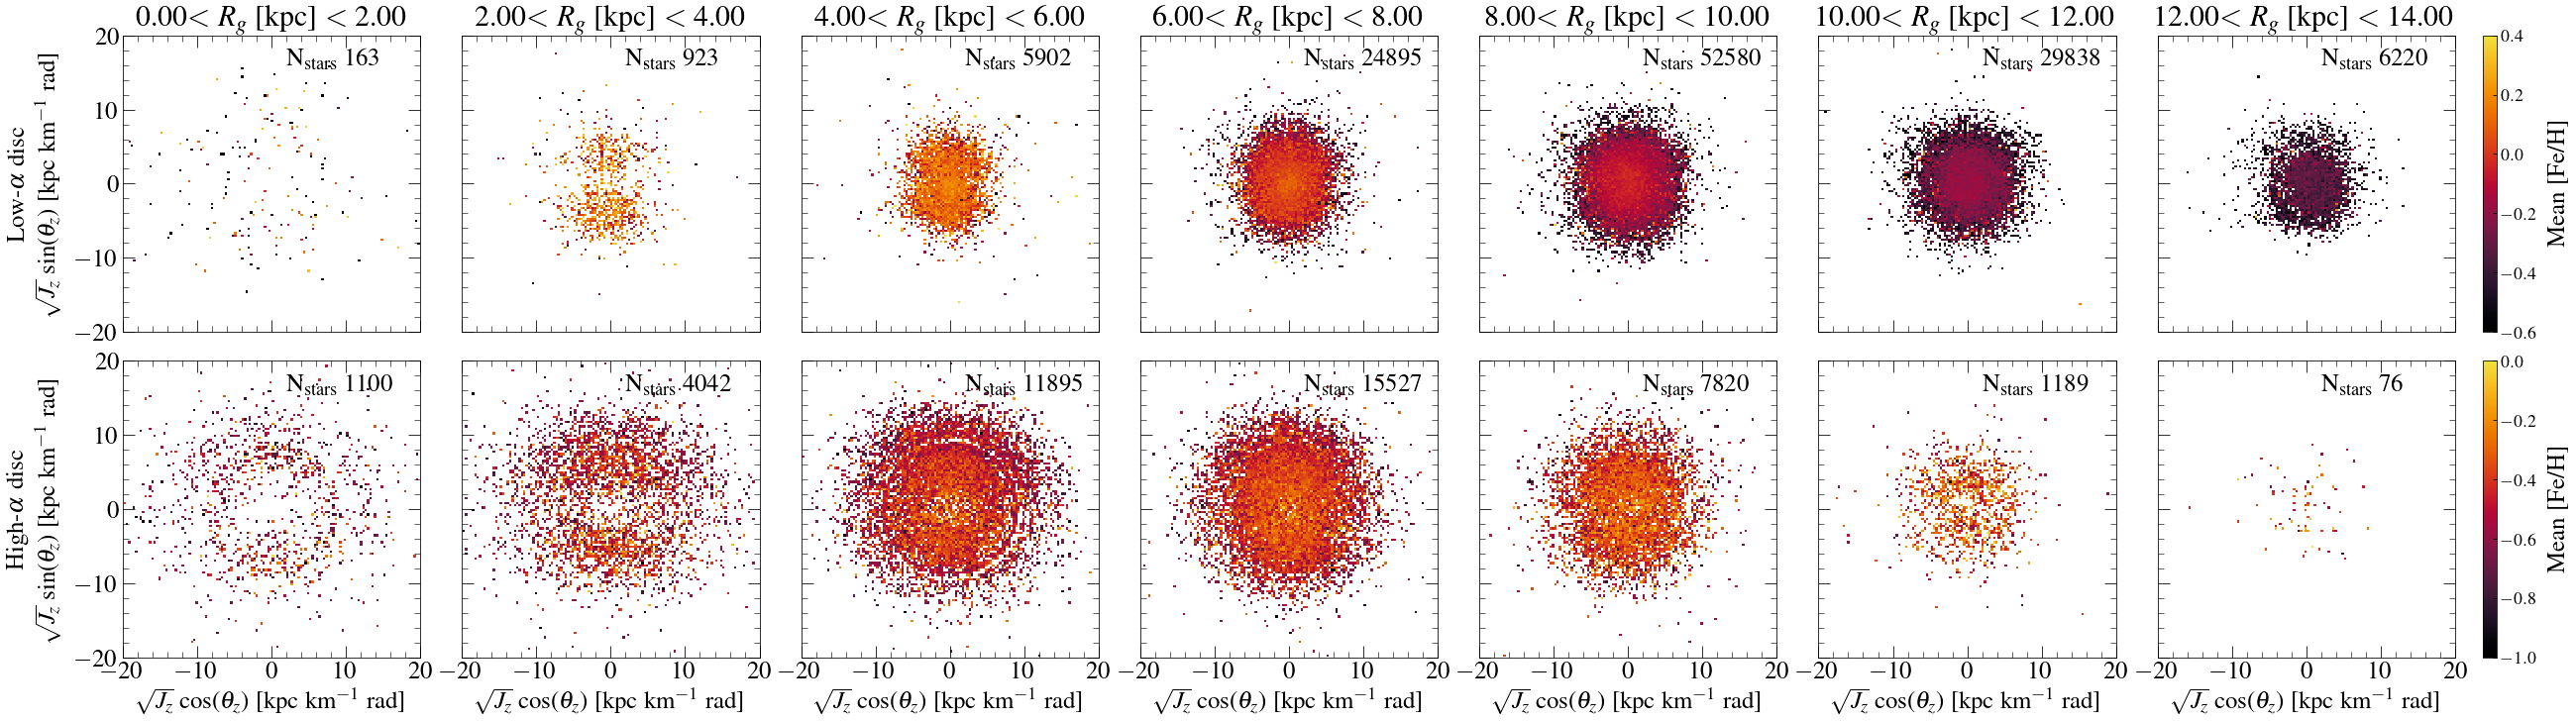

In [65]:
plot_3_3(Rg,z_x2,z_y2, data['FE_H'],lowa_plot,higha_plot,label1=r'$R_g$ [kpc]',\
         label2 = r'$\sqrt{J_{z}}$ cos($\theta_{z}$) [kpc km$^{-1}$ rad]',\
         label3=r'$\sqrt{J_{z}}$ sin($\theta_{z}$) [kpc km$^{-1}$ rad]',xfe_label=r'Mean [Fe/H]',\
            xlim1 = -20, xlim2 = 20, ylim1 =-20, ylim2 = 20,xnstar = 2, ynstar = 16,nbins=128)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/vertical-OTI-feh.pdf',dpi=200, bbox_inches = 'tight')


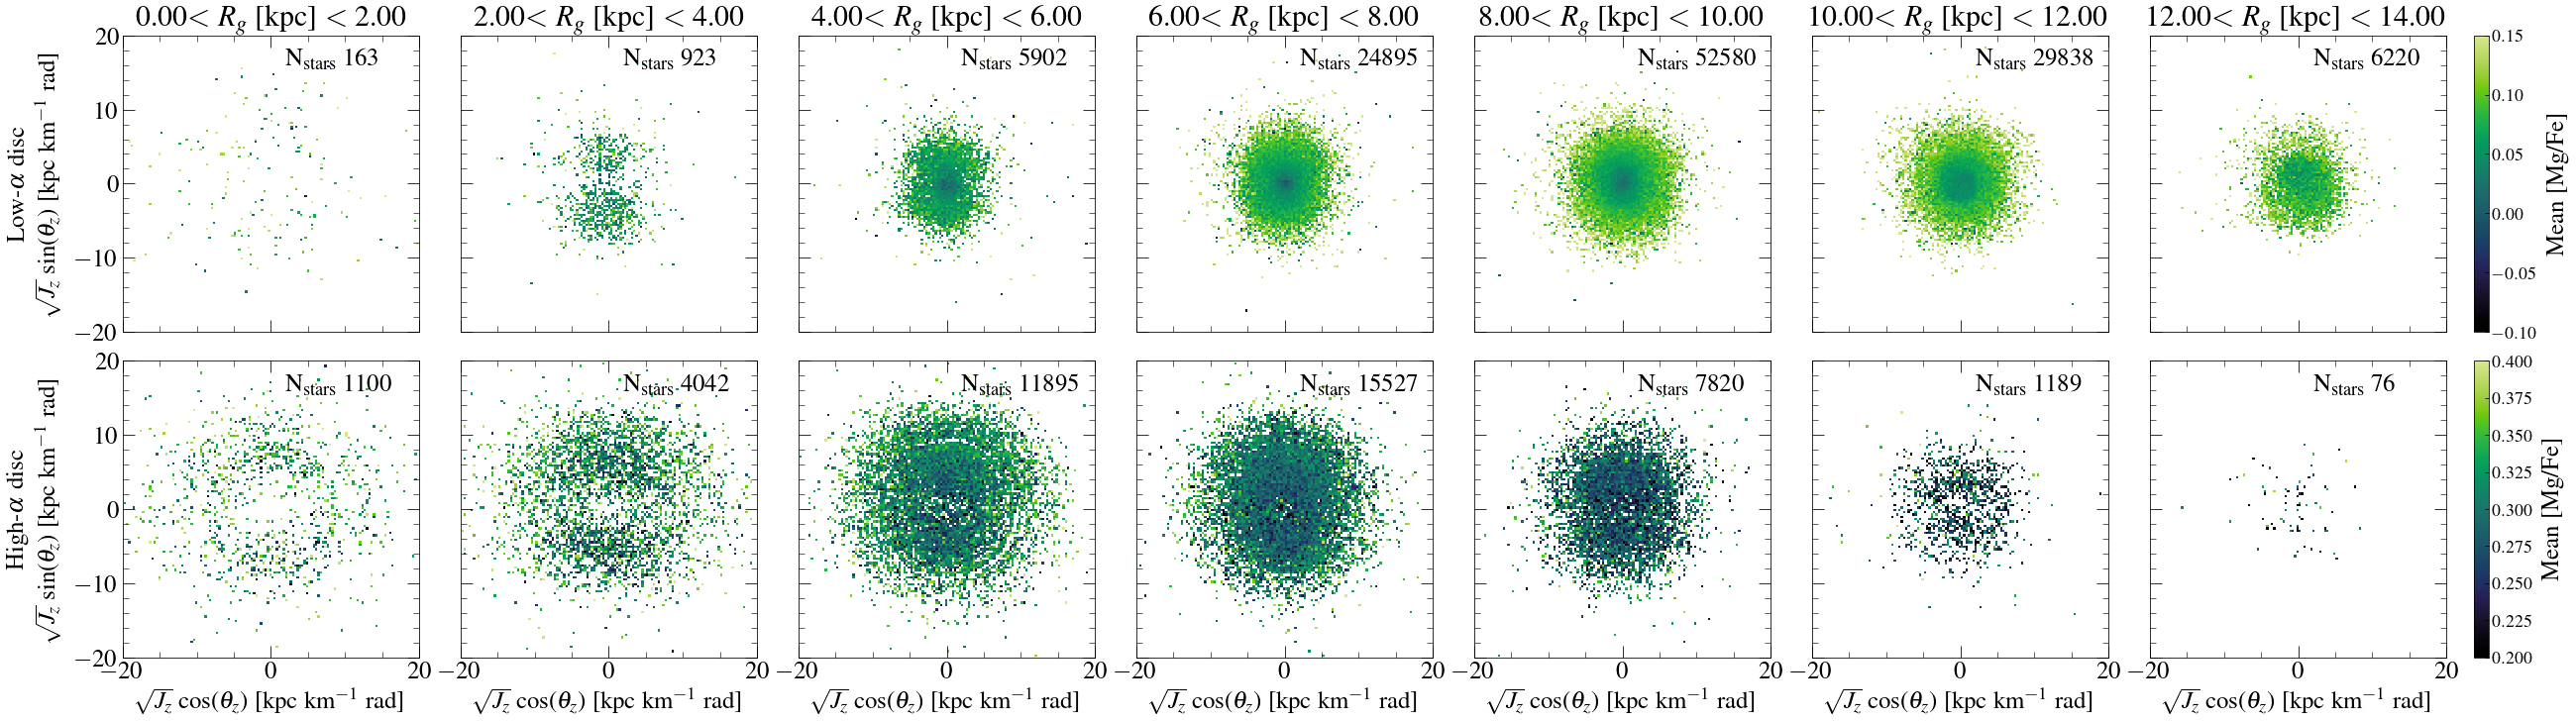

In [74]:
plot_3_3(Rg,z_x2,z_y2, data['MG_FE'],lowa_plot,higha_plot,label1=r'$R_g$ [kpc]',\
                  label2 = r'$\sqrt{J_{z}}$ cos($\theta_{z}$) [kpc km$^{-1}$ rad]',\
         label3=r'$\sqrt{J_{z}}$ sin($\theta_{z}$) [kpc km$^{-1}$ rad]',xfe_label=r'Mean [Mg/Fe]',\
            xlim1 = -20, xlim2 = 20, ylim1 =-20, ylim2 = 20,xnstar = 2, ynstar = 16,nbins=128)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/vertical-OTI-mgfe.pdf',dpi=200, bbox_inches = 'tight')
